# Identifikácia phishingových webových stránok pomocou ML

**Meno**: Bc. Tomáš Brček \
**Škola**: Slovenská technická univerzita v Bratislave \
**Fakulta**: Fakulta informatiky a informačných technológií \
**Rok**: 2025/2026

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
from utils.utils import add_missing_flags

## Load datasets

In [2]:
df_legitimate = pd.read_csv("../dataset/df_benign.csv")
print("Legitimate URLs:", df_legitimate.shape)
df_legitimate.head()

Legitimate URLs: (10000, 25)


,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,0,https://www.123people.ca/s/richard+bigras,41,16,17,0,1,2,0,0,...,0,0,0,3,123people,ca,3.327820,1657,168,1826
1,0,https://www.123people.ca/s/paolo+violi,38,16,14,0,1,2,0,0,...,0,0,0,3,123people,ca,3.327820,1657,168,1826
2,0,https://www.thecheapseats.ca/2010/02/alexandre...,121,20,93,0,1,2,11,0,...,0,0,0,3,thecheapseats,ca,3.108695,1874,316,2191
3,0,https://www.facebook.com/pages/Joe-Bravo/13583...,56,16,32,0,1,2,1,0,...,0,0,0,3,facebook,com,3.155639,10439,3075,13514
4,0,https://www.gawker.com/5135947/shira-lazar-kev...,67,14,45,0,1,2,5,0,...,0,0,0,3,gawker,com,3.093069,8423,1803,10227


In [3]:
df_phishing = pd.read_csv("../dataset/df_phishing.csv")
print("Phishing URLs:", df_phishing.shape)
df_phishing.head()

Phishing URLs: (10000, 25)


,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,1,https://www-coursier-urgent.com/as.php,38,23,7,0,1,1,2,0,...,0,0,0,0,www-coursier-urgent,com,3.675311,41,323,365
1,1,https://brt-it.online/pay,25,13,4,0,1,1,1,0,...,0,0,0,0,brt-it,online,3.238901,34,331,365
2,1,https://00-lhvpromt.com/LHV/,28,15,5,0,1,1,1,0,...,0,0,0,0,00-lhvpromt,com,3.506891,177,187,365
3,1,https://new.express.adobe.com/webpage/Ohdj40xE...,51,21,22,0,1,3,0,0,...,0,0,0,11,adobe,com,3.594466,14224,201,14425
4,1,https://biglobewemail3s.weebly.com/,35,26,1,0,1,2,0,0,...,0,0,0,15,weebly,com,3.642371,7152,152,7304


In [4]:
df_all = pd.concat([df_legitimate, df_phishing], ignore_index=True)
print("All URLs:", df_all.shape)
df_all.head()

All URLs: (20000, 25)


,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,0,https://www.123people.ca/s/richard+bigras,41,16,17,0,1,2,0,0,...,0,0,0,3,123people,ca,3.327820,1657,168,1826
1,0,https://www.123people.ca/s/paolo+violi,38,16,14,0,1,2,0,0,...,0,0,0,3,123people,ca,3.327820,1657,168,1826
2,0,https://www.thecheapseats.ca/2010/02/alexandre...,121,20,93,0,1,2,11,0,...,0,0,0,3,thecheapseats,ca,3.108695,1874,316,2191
3,0,https://www.facebook.com/pages/Joe-Bravo/13583...,56,16,32,0,1,2,1,0,...,0,0,0,3,facebook,com,3.155639,10439,3075,13514
4,0,https://www.gawker.com/5135947/shira-lazar-kev...,67,14,45,0,1,2,5,0,...,0,0,0,3,gawker,com,3.093069,8423,1803,10227


In [5]:
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.replace(-1, pd.NA, inplace=True)

df_all["domain_age"] = pd.to_numeric(df_all["domain_age"], errors='coerce').astype("Int64")
df_all["days_to_expire"] = pd.to_numeric(df_all["days_to_expire"], errors='coerce').astype("Int64")
df_all["registration_length"] = pd.to_numeric(df_all["registration_length"], errors='coerce').astype("Int64")

df_all.head()

,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,1,https://fix-error-page.web.app/,31,22,1,0,1,2,2,0,...,0,0,0,14,web,app,3.538311,<NA>,<NA>,<NA>
1,0,https://www.english.turkcebilgi.com/Wang+(surn...,50,27,15,0,1,3,0,0,...,0,0,0,11,turkcebilgi,com,3.930270,7719,1411,9131
2,0,https://www.manta.com/ic/mtqdy33/ca/rivet-patr...,80,13,59,0,1,2,6,0,...,0,0,0,3,manta,com,2.873141,7963,72,8036
3,0,https://www.allposters.com/-st/William-Vandive...,69,18,43,0,1,2,3,0,...,0,0,0,3,allposters,com,3.461320,9865,360,10226
4,1,https://sloks.bubbleapps.io/version-test,40,19,13,0,1,2,1,0,...,0,0,0,5,bubbleapps,io,3.326360,3574,1904,5479


## EDA

In [6]:
df_all.dtypes

phishing                 int64
url                     object
url_len                  int64
host_len                 int64
path_len                 int64
query_len                int64
is_https                 int64
count_dots               int64
count_hyphen             int64
count_at                 int64
count_qm                 int64
count_eq                 int64
count_slash              int64
count_double_slash       int64
count_digits             int64
has_ip                   int64
has_shortener            int64
has_keyword              int64
subdomain_len            int64
domain                  object
suffix                  object
domain_entropy         float64
domain_age               Int64
days_to_expire           Int64
registration_length      Int64
dtype: object

In [7]:
df_all.isnull().sum()

phishing                  0
url                       0
url_len                   0
host_len                  0
path_len                  0
query_len                 0
is_https                  0
count_dots                0
count_hyphen              0
count_at                  0
count_qm                  0
count_eq                  0
count_slash               0
count_double_slash        0
count_digits              0
has_ip                    0
has_shortener             0
has_keyword               0
subdomain_len             0
domain                    0
suffix                   68
domain_entropy            0
domain_age             3159
days_to_expire         3198
registration_length    3196
dtype: int64

In [8]:
df_all.shape[0] - df_all.dropna().shape[0]

3201

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   phishing             20000 non-null  int64  
 1   url                  20000 non-null  object 
 2   url_len              20000 non-null  int64  
 3   host_len             20000 non-null  int64  
 4   path_len             20000 non-null  int64  
 5   query_len            20000 non-null  int64  
 6   is_https             20000 non-null  int64  
 7   count_dots           20000 non-null  int64  
 8   count_hyphen         20000 non-null  int64  
 9   count_at             20000 non-null  int64  
 10  count_qm             20000 non-null  int64  
 11  count_eq             20000 non-null  int64  
 12  count_slash          20000 non-null  int64  
 13  count_double_slash   20000 non-null  int64  
 14  count_digits         20000 non-null  int64  
 15  has_ip               20000 non-null 

### Kategorické stĺpce

In [10]:
df_all.describe(exclude=np.number)

,url,domain,suffix
count,20000,20000,19932
unique,19999,6789,236
top,"""https://www.adsensecustomsearchads.com/afs/ad...",google,com
freq,2,1492,12616


In [11]:
for col in df_all.select_dtypes(exclude=['number']).columns:
    print(f"Value counts for column '{col}':")
    print(df_all[col].value_counts())
    print("\n")

Value counts for column 'url':
url
"https://www.adsensecustomsearchads.com/afs/ads?adtest=off&psid=3113057640&pcsa=false&channel=pid-bodis-gcontrol202                                                                        2
https://www.mattrobersononline.com/                                                                                                                                                        1
https://www.axiumplastics.com/                                                                                                                                                             1
https://smbcrdvpss.sbs/ja                                                                                                                                                                  1
https://www.technologyreview.com/tr50/brightsource/                                                                                                                                        1
                    

### Numerické stĺpce

In [12]:
df_all.describe()

,phishing,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,count_qm,...,count_double_slash,count_digits,has_ip,has_shortener,has_keyword,subdomain_len,domain_entropy,domain_age,days_to_expire,registration_length
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.00000,20000.000000,20000.000000,20000.00000,20000.000000,20000.00000,20000.000000,16841.0,16802.0,16804.0
mean,0.500000,60.743050,19.737150,24.691550,8.075300,0.972300,2.034250,1.152750,0.005000,0.168950,...,0.01020,5.056350,0.003150,0.03255,0.034450,6.82805,3.357537,7478.648833,693.626592,8175.376517
std,0.500013,49.524292,9.908313,29.856937,34.971221,0.164116,0.595982,2.248793,0.071241,0.392573,...,0.11915,9.464975,0.056038,0.17746,0.182387,9.13164,0.473179,3311.376996,839.478289,3487.692743
min,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,-1307.0,364.0
25%,0.000000,34.000000,15.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,3.00000,3.002172,5244.0,167.0,6209.0
50%,0.500000,47.000000,18.000000,14.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.00000,1.000000,0.000000,0.00000,0.000000,3.00000,3.367067,8010.0,340.0,8766.0
75%,1.000000,69.000000,24.000000,33.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.00000,7.000000,0.000000,0.00000,0.000000,9.00000,3.684184,10269.0,1052.0,10958.0
max,1.000000,1202.000000,102.000000,457.000000,1148.000000,1.000000,11.000000,41.000000,2.000000,4.000000,...,3.00000,216.000000,1.000000,1.00000,1.000000,95.00000,4.862849,14796.0,30050.0,38350.0


In [13]:
for ds in [df_all]:
    for col in ds.select_dtypes(include=['number']).columns:
        mean_value = round(np.mean(ds[col]), 3)
        median_value = round(np.median(ds[col]), 3)
        mode_result = stats.mode(ds[col], nan_policy='omit')
        try:
            mode_value = mode_result.mode[0]
        except IndexError: 
            mode_value = None
        mode_display = mode_value if mode_value is not None else "N/A"
        print(f"{col:30} -> Mean: {mean_value:>8}, Median: {median_value:>8}, Mode: {mode_display:>8}")

phishing                       -> Mean:      0.5, Median:      0.5, Mode:      N/A
url_len                        -> Mean:   60.743, Median:     47.0, Mode:      N/A
host_len                       -> Mean:   19.737, Median:     18.0, Mode:      N/A
path_len                       -> Mean:   24.692, Median:     14.0, Mode:      N/A
query_len                      -> Mean:    8.075, Median:      0.0, Mode:      N/A
is_https                       -> Mean:    0.972, Median:      1.0, Mode:      N/A
count_dots                     -> Mean:    2.034, Median:      2.0, Mode:      N/A
count_hyphen                   -> Mean:    1.153, Median:      0.0, Mode:      N/A
count_at                       -> Mean:    0.005, Median:      0.0, Mode:      N/A
count_qm                       -> Mean:    0.169, Median:      0.0, Mode:      N/A
count_eq                       -> Mean:    0.392, Median:      0.0, Mode:      N/A
count_slash                    -> Mean:    4.067, Median:      3.0, Mode:      N/A
coun

In [14]:
def evaluate_skewness(skewness: float) -> str:
    if -0.5 <= skewness <= 0.5:
        return f"Slightly skewed to the {'left' if skewness > 0 else 'right'}"
    elif -1 < skewness < -0.5 or 0.5 < skewness < 1:
        return f"Moderately skewed to the {'left' if skewness > 0 else 'right'}"
    elif skewness <= -1 or skewness >= 1:
        return f"Highly skewed to the {'left' if skewness > 0 else 'right'}"
    else:
        return "Invalid value."

In [15]:
def evaluate_kurtosis(kurtosis: float) -> str:
    if kurtosis > 3:
        return "Kurtosis is high."
    elif kurtosis < 3:
        return "Kurtosis is low."

In [16]:
for col in df_all.select_dtypes(include=['number']).columns:
    skewness_value = round(stats.skew(df_all[col].dropna()), 3)
    kurtosis_value = round(stats.kurtosis(df_all[col].dropna()), 3)
    skewness_eval = evaluate_skewness(skewness_value)
    kurtosis_eval = evaluate_kurtosis(kurtosis_value)
    
    print(f"{col:27} Skewness: {skewness_value:>8} -> {skewness_eval:<30} Kurtosis: {kurtosis_value:>8} -> {kurtosis_eval}")

phishing                    Skewness:      0.0 -> Slightly skewed to the right   Kurtosis:     -2.0 -> Kurtosis is low.
url_len                     Skewness:    5.414 -> Highly skewed to the left      Kurtosis:   71.102 -> Kurtosis is high.
host_len                    Skewness:    1.948 -> Highly skewed to the left      Kurtosis:    7.455 -> Kurtosis is high.
path_len                    Skewness:    2.186 -> Highly skewed to the left      Kurtosis:    8.852 -> Kurtosis is high.
query_len                   Skewness:   12.693 -> Highly skewed to the left      Kurtosis:  260.282 -> Kurtosis is high.
is_https                    Skewness:   -5.756 -> Highly skewed to the right     Kurtosis:    31.13 -> Kurtosis is high.
count_dots                  Skewness:    0.716 -> Moderately skewed to the left  Kurtosis:    5.029 -> Kurtosis is high.
count_hyphen                Skewness:    4.132 -> Highly skewed to the left      Kurtosis:    28.69 -> Kurtosis is high.
count_at                    Skewn

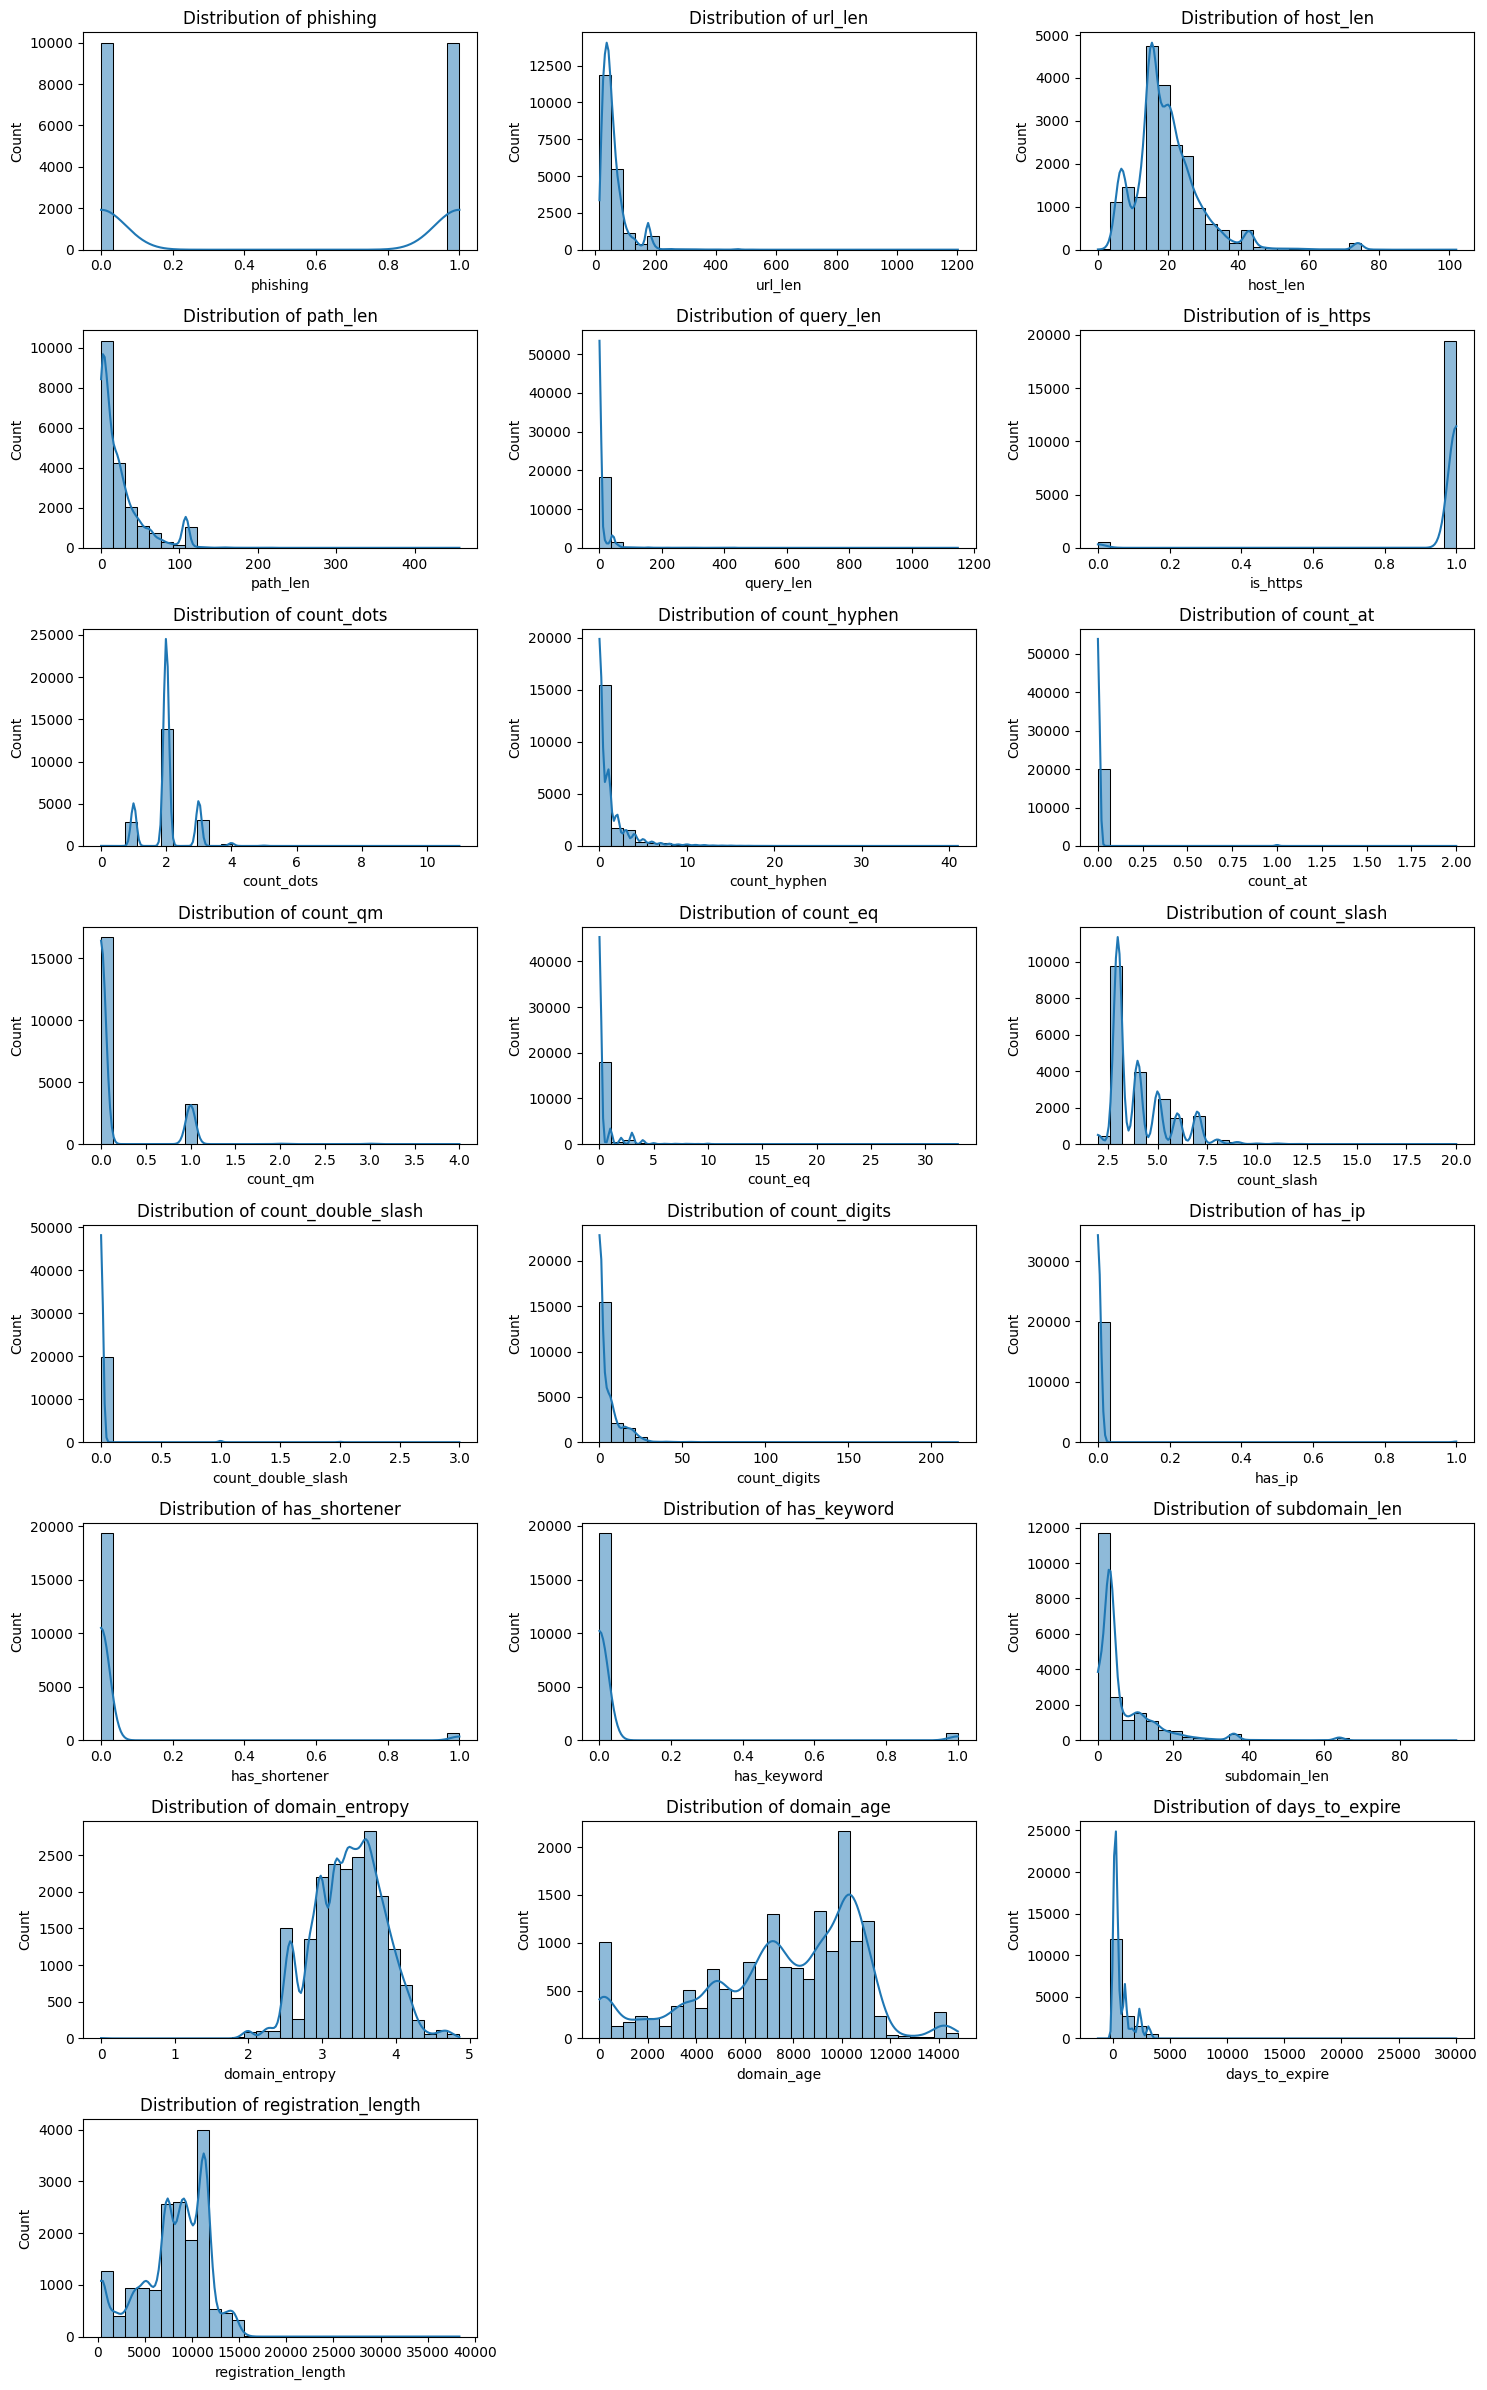

In [17]:
num_cols = 3
numeric_cols = df_all.select_dtypes(include=['number']).columns
num_plots = len(numeric_cols)

num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

if num_rows > 0:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df_all[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

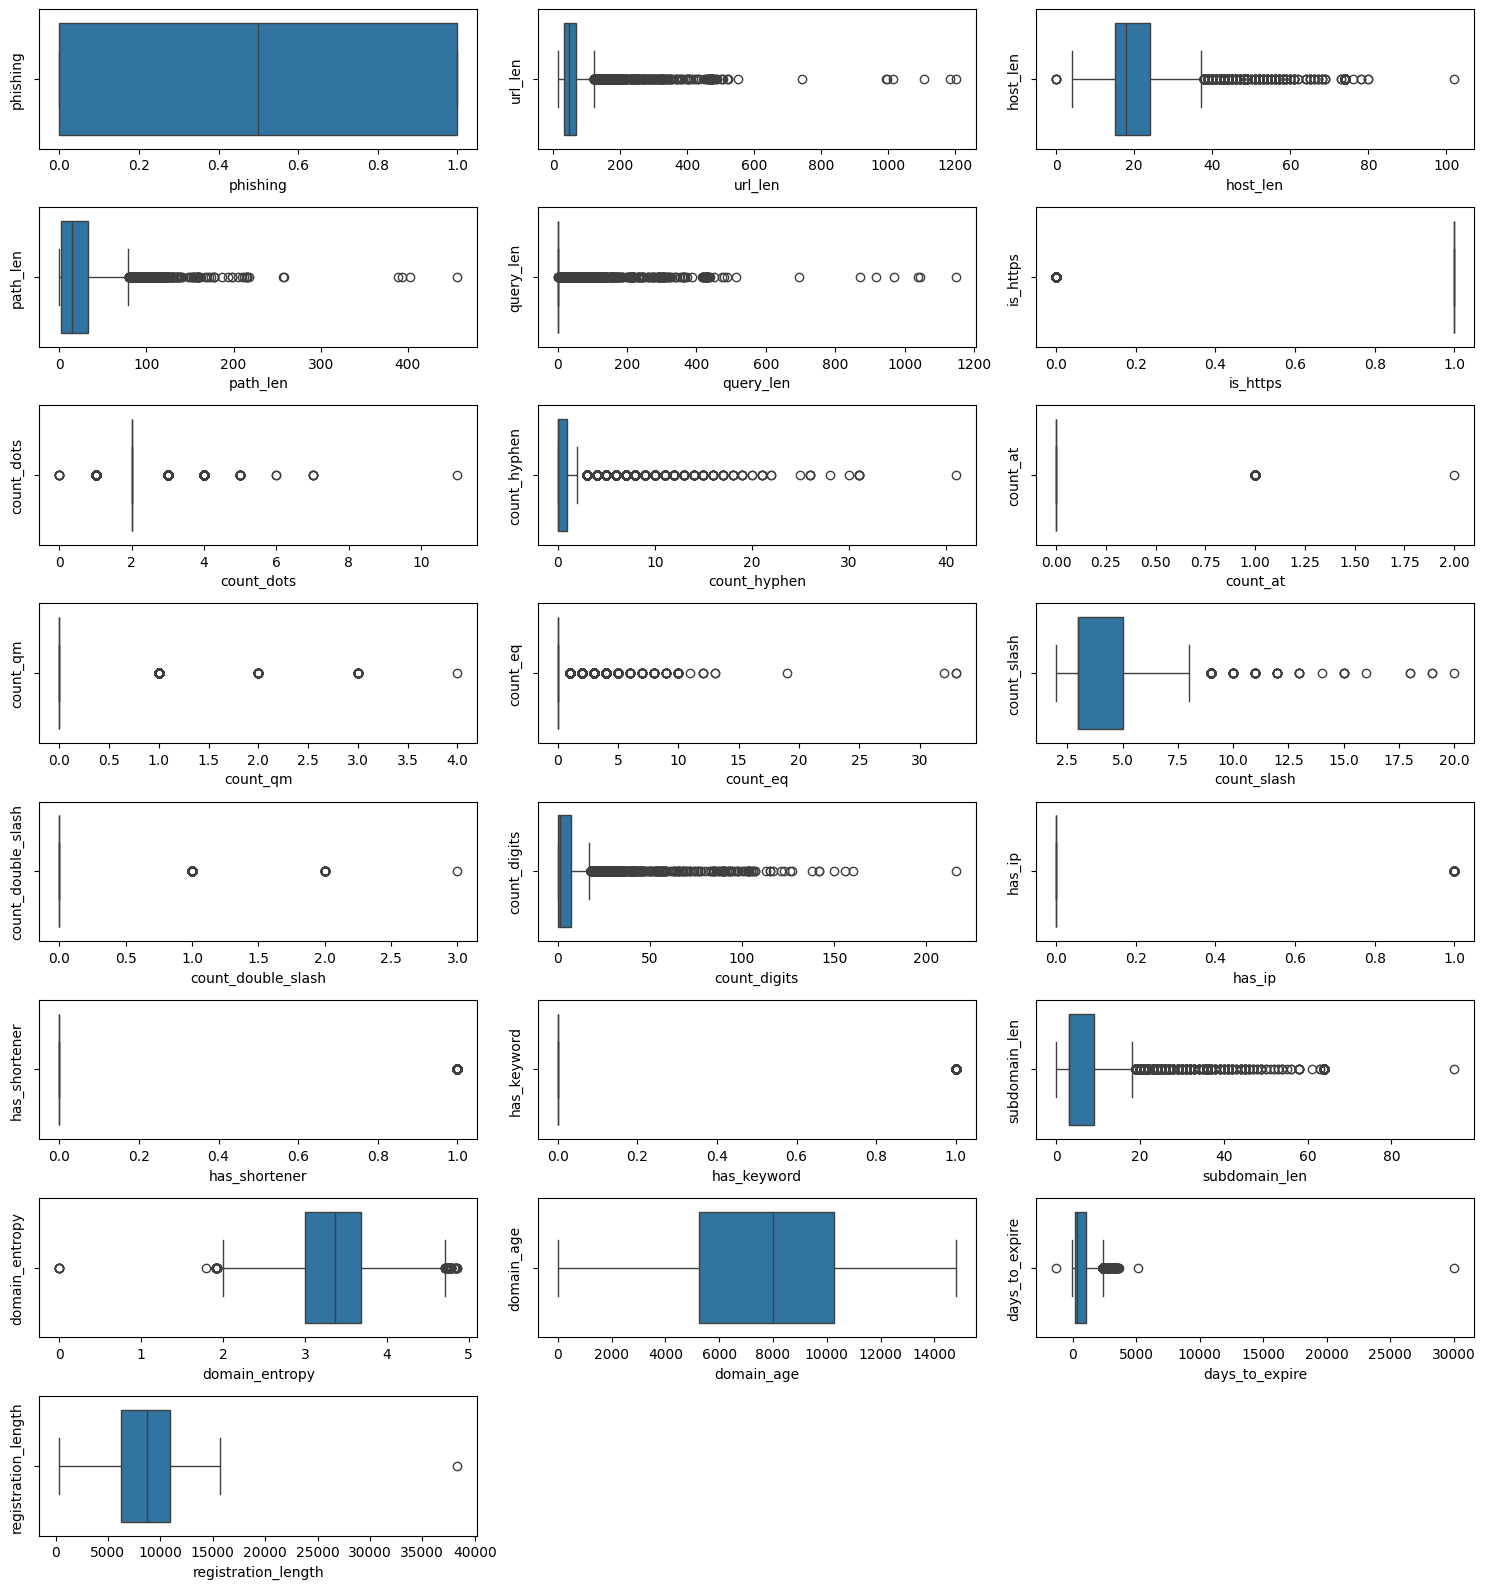

In [18]:
numeric_cols = df_all.select_dtypes(include=['number']).columns
num_plots = len(numeric_cols)

num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

if num_rows > 0:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 2))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=col, data=df_all, ax=axes[i])
        axes[i].set_ylabel(col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Párová analýza

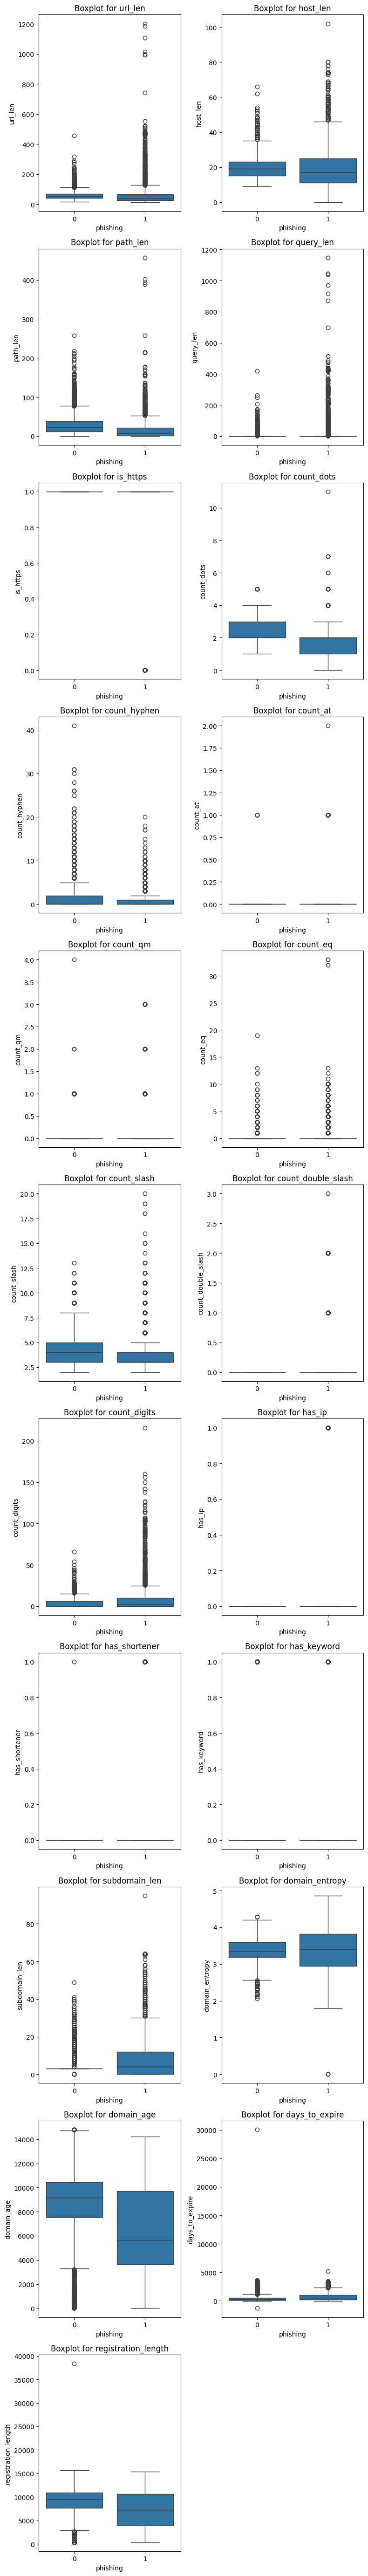

In [19]:
num_cols = len(df_all.columns)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, rows * 5))
axes = axes.flatten()

for i, col in enumerate(df_all.drop(columns=["phishing", "domain", "url", "suffix"]).columns):
    sns.boxplot(x='phishing', y=col, data=df_all, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

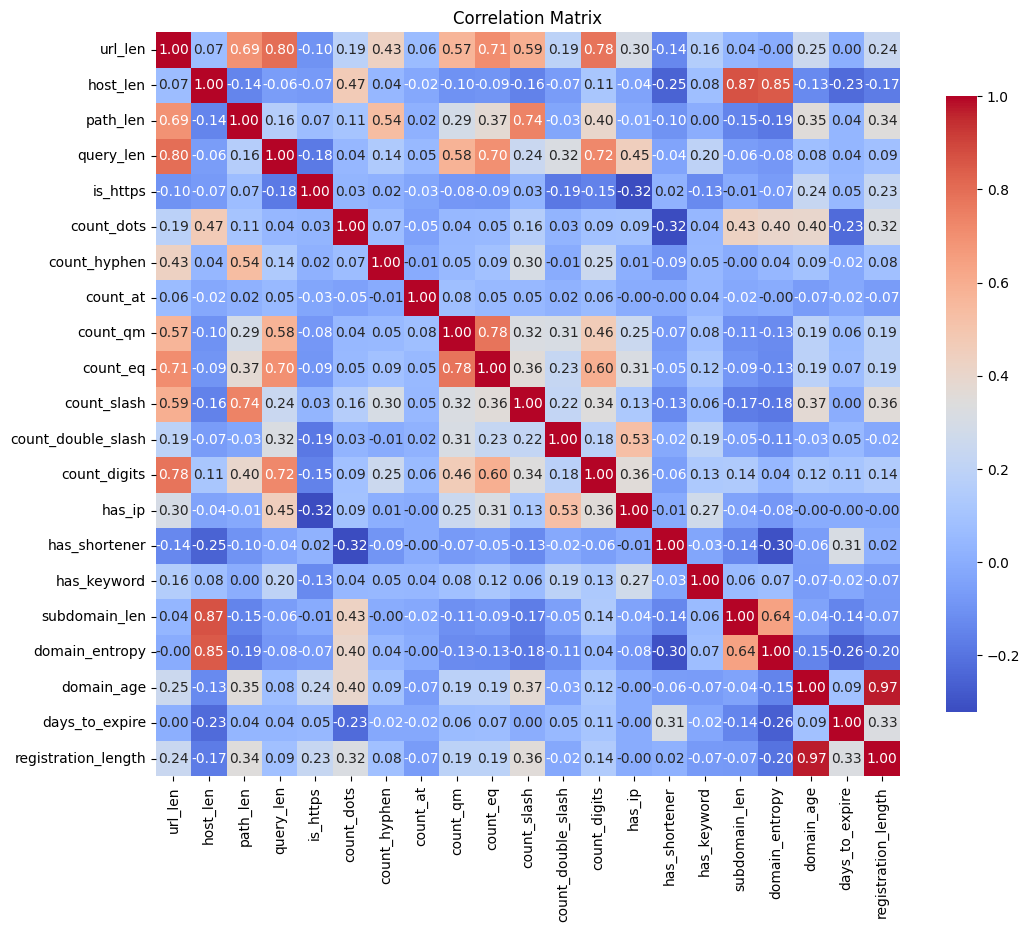

In [20]:
# correlation of each column with phishing column put into matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_all.drop(columns=["phishing", "domain", "url", "suffix"]).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

### Odstránenie duplikátov

In [21]:
rows_duplicates = df_all[df_all.duplicated()]
len(rows_duplicates)

1

In [22]:
df_all.drop_duplicates(inplace=True)

In [23]:
columns_duplicates = df_all.T[df_all.T.duplicated()]
len(columns_duplicates)

0

In [24]:
for col in df_all.columns:
    print(f"{col:20}: {len(df_all[col].unique())}")

phishing            : 2
url                 : 19999
url_len             : 325
host_len            : 72
path_len            : 174
query_len           : 251
is_https            : 2
count_dots          : 9
count_hyphen        : 29
count_at            : 3
count_qm            : 5
count_eq            : 17
count_slash         : 18
count_double_slash  : 4
count_digits        : 115
has_ip              : 2
has_shortener       : 2
has_keyword         : 2
subdomain_len       : 62
domain              : 6789
suffix              : 237
domain_entropy      : 2255
domain_age          : 3957
days_to_expire      : 1357
registration_length : 572


In [25]:
df_all.isnull().sum()

phishing                  0
url                       0
url_len                   0
host_len                  0
path_len                  0
query_len                 0
is_https                  0
count_dots                0
count_hyphen              0
count_at                  0
count_qm                  0
count_eq                  0
count_slash               0
count_double_slash        0
count_digits              0
has_ip                    0
has_shortener             0
has_keyword               0
subdomain_len             0
domain                    0
suffix                   67
domain_entropy            0
domain_age             3158
days_to_expire         3197
registration_length    3195
dtype: int64

In [26]:
numeric_cols = df_all.select_dtypes(include=['number'])

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)

IQR = Q3 - Q1

outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | 
            (numeric_cols > (Q3 + 1.5 * IQR)))

outliers_count = outliers.sum()

print(outliers_count)

phishing                  0
url_len                1706
host_len                951
path_len               1465
query_len              3275
is_https                553
count_dots             6111
count_hyphen           2833
count_at                 99
count_qm               3277
count_eq               3221
count_slash             174
count_double_slash      164
count_digits           1608
has_ip                   63
has_shortener           651
has_keyword             689
subdomain_len          1549
domain_entropy           76
domain_age                0
days_to_expire         1297
registration_length       1
dtype: Int64


## Príprava na trénovanie

In [27]:
train_df, test_df = train_test_split(df_all, test_size=0.25, random_state=42)
print(train_df.shape)
print(test_df.shape)

(14999, 25)
(5000, 25)


### Výber stĺpcov

In [28]:
"""
from sklearn.feature_selection import f_classif, SelectKBest

X = train_df.drop(columns="phishing")
y = train_df["phishing"]

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = anova_selector.scores_
selected_columns = X.columns
imp_columns = []

anova_features_scores = sorted(zip(selected_columns, anova_scores), key=lambda x: x[1], reverse=True)

for feature, score in anova_features_scores:
    print(f"Feature: {feature:28} Score: {score}")
    if score > 50:
        imp_columns.append(feature)
"""

'\nfrom sklearn.feature_selection import f_classif, SelectKBest\n\nX = train_df.drop(columns="phishing")\ny = train_df["phishing"]\n\nanova_selector = SelectKBest(score_func=f_classif, k=\'all\')\nanova_selector.fit(X, y)\nanova_scores = anova_selector.scores_\nselected_columns = X.columns\nimp_columns = []\n\nanova_features_scores = sorted(zip(selected_columns, anova_scores), key=lambda x: x[1], reverse=True)\n\nfor feature, score in anova_features_scores:\n    print(f"Feature: {feature:28} Score: {score}")\n    if score > 50:\n        imp_columns.append(feature)\n'

## Pipeline

### Testovanie rôznych modelov

In [29]:
numeric_cols = ['domain_age', 'registration_length', 'domain_entropy', 'host_len', 'count_slash', 'subdomain_len', 'path_len', 'count_hyphen', 'domain_age', 'registration_length', 'days_to_expire', 'url_len', 'count_eq']
categorical_cols = ['suffix', 'domain']
binary_cols = ['is_https', 'has_keyword', 'has_ip', 'has_shortener']
flag_cols = ['domain_age', 'registration_length', 'days_to_expire']

columns = ['suffix', 'domain_age', 'registration_length', 'domain_entropy', 'is_https', 'domain_freq', 'host_len', 'count_slash', 'path_len', 'count_hyphen',
 'domain_age_missing', 'registration_length_missing', 'days_to_expire_missing', 'has_keyword', 'count_eq', 'has_ip', 'has_shortener']

missing_flagger = FunctionTransformer(add_missing_flags)

num_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("power", PowerTransformer(method="yeo-johnson")),
    ("scaler", RobustScaler())
])

domain_encoder = ce.CountEncoder(cols=["domain"])
suffix_encoder = ce.TargetEncoder(cols=["suffix"])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols),
        ("domain", domain_encoder, ["domain"]),
        ("suffix", suffix_encoder, ["suffix"]),
    ],
    remainder="drop"
)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42
)

lr = LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42
)

svm = SVC(probability=True, class_weight="balanced", random_state=42)

ensemble = VotingClassifier(
    estimators=[("rf", rf), ("lr", lr)],
    voting="soft"
)

classifiers = {
    "RandomForest": rf,
    "LogisticRegression": lr,
    "SVM": svm,
    "Ensemble": ensemble
}


In [31]:
n_samples = train_df["phishing"].value_counts().min()
train_balanced = train_df.groupby('phishing').sample(n=n_samples, random_state=42)
print(train_balanced['phishing'].value_counts())

phishing
0    7431
1    7431
Name: count, dtype: int64


In [32]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score

results = []

X_train = train_balanced.drop(columns=["url", "phishing"])
y_train = train_balanced["phishing"]

for name, model in classifiers.items():
    clf = Pipeline(steps=[
        ("missing_flags", missing_flagger),
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=["accuracy", "recall"])
    results.append({
        "model": name,
        "mean_recall": cv_results["test_recall"].mean(),
        "mean_accuracy": cv_results["test_accuracy"].mean(),
    })

results_df = pd.DataFrame(results)
results_df


,model,mean_recall,mean_accuracy
0,RandomForest,0.966897,0.977123
1,LogisticRegression,0.865428,0.906742
2,SVM,0.519447,0.747612
3,Ensemble,0.946577,0.964675


### Najlepší model

In [33]:
clf = Pipeline(steps=[
    ("missing_flags", missing_flagger),
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42)
    )
])

In [34]:
X_train = train_balanced.drop(columns=["url", "phishing"])
y_train = train_balanced["phishing"]

clf.fit(X_train, y_train)

,steps,"[('missing_flags', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function add...x7bd586265ee0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [35]:
X_test = test_df.drop(columns=["url", "phishing"])
y_test = test_df["phishing"]

y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\n Recall Score:")
print(recall_score(y_test, y_pred))

Confusion Matrix:
[[2540   29]
 [  99 2332]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2569
           1       0.99      0.96      0.97      2431

    accuracy                           0.97      5000
   macro avg       0.98      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000


Accuracy Score:
0.9744

 Recall Score:
0.9592760180995475


In [36]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# predikcie na tréningoch
y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# predikcie na testoch
y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Train recall: {train_recall:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Train F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")


Train accuracy: 0.9825
Test accuracy: 0.9744
Train recall: 0.9724
Test recall: 0.9593
Train F1: 0.9823
Test F1: 0.9733
Train Precision: 0.9924
Test Precision: 0.9877


In [37]:
from sklearn.model_selection import cross_validate

# cross-validation na tréningových dátach
X = df_all.drop(columns=["url", "phishing"])
y = df_all["phishing"]

cv_results = cross_validate(clf, X, y, cv=5, scoring=["accuracy", "recall"], n_jobs=-1)
print("CV accuracy scores:", cv_results["test_accuracy"])
print("Mean CV accuracy:", np.mean(cv_results["test_accuracy"]))
print("CV recall scores:", cv_results["test_recall"])
print("Mean CV recall:", np.mean(cv_results["test_recall"]))


CV accuracy scores: [0.97925    0.97975    0.974      0.976      0.97474369]
Mean CV accuracy: 0.9767487371842961
CV recall scores: [0.967      0.974      0.9595     0.9615     0.96248124]
Mean CV recall: 0.9648962481240619


In [38]:
import joblib

joblib.dump(clf, "../phishing_pipeline.pkl")

['../phishing_pipeline.pkl']

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score
import numpy as np

def tune_random_forest(clf, X_train, y_train, scoring="recall"):
    """
    clf: pipeline s RandomForestClassifier ako posledným krokom
    X_train, y_train: tréningové dáta
    scoring: 'recall' (default), alebo 'f1', 'precision', ...
    """
    
    # priame nastavenie na classifier vo vnútri pipeline
    param_dist = {
        "classifier__n_estimators": [100, 200, 300, 500],
        "classifier__max_depth": [5, 10, 15, 20, None],
        "classifier__min_samples_split": [2, 5, 10, 20],
        "classifier__min_samples_leaf": [1, 2, 5, 10],
        "classifier__max_features": ["sqrt", "log2", None],
        "classifier__class_weight": [None, "balanced", "balanced_subsample"]
    }
    
    # scorer priamo na recall pre phishing triedu (=1)
    scorer = make_scorer(recall_score, pos_label=1)
    
    search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        n_iter=40,                  # počet kombinácií na vyskúšanie
        scoring=scorer,             # optimalizujeme recall
        cv=5,                       # 5-fold cross validation
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)
    print("Best recall:", search.best_score_)
    
    return search.best_estimator_


In [40]:
best_clf = tune_random_forest(clf, X_train, y_train, scoring="recall")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  18.2s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  19.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  20.2s
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=500; total time=  31.1s
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__m

In [41]:
from sklearn.model_selection import cross_validate

# cross-validation na tréningových dátach
X = df_all.drop(columns=["url", "phishing"])
y = df_all["phishing"]

cv_results = cross_validate(best_clf, X, y, cv=5, scoring=["accuracy", "recall", "f1", "precision"], n_jobs=-1)
print("CV accuracy scores:", cv_results["test_accuracy"])
print("Mean CV accuracy:", np.mean(cv_results["test_accuracy"]))
print("CV recall scores:", cv_results["test_recall"])
print("Mean CV recall:", np.mean(cv_results["test_recall"]))
print("CV F1 scores:", cv_results["test_f1"])
print("Mean CV F1:", np.mean(cv_results["test_f1"]))
print("CV Precision scores:", cv_results["test_precision"])
print("Mean CV Precision:", np.mean(cv_results["test_precision"]))


CV accuracy scores: [0.99025    0.984      0.9875     0.98375    0.98124531]
Mean CV accuracy: 0.9853490622655665
CV recall scores: [0.9885     0.9825     0.9865     0.977      0.97648824]
Mean CV recall: 0.9821976488244122
CV F1 scores: [0.99023291 0.98397596 0.98748749 0.98363957 0.98115104]
Mean CV F1: 0.9852973938150166
CV Precision scores: [0.9919719  0.98545637 0.98847695 0.99036999 0.98585859]
Mean CV Precision: 0.988426761092219


In [42]:
import joblib

joblib.dump(clf, "../phishing_pipeline.pkl")

['../phishing_pipeline.pkl']